<a href="https://colab.research.google.com/github/budarapusaketh89-ux/FUTURE_FS_01/blob/main/ASIT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle
!pip install librosa

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"uihoij","key":"88dd13769954ea31dd10e52580e3b409"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d aklimarimi/audio-classifier-dataset

Dataset URL: https://www.kaggle.com/datasets/aklimarimi/audio-classifier-dataset
License(s): CC0-1.0
100% 4.75G/4.75G [01:17<00:00, 89.8MB/s]
100% 4.75G/4.75G [01:18<00:00, 65.1MB/s]


In [ ]:
# Download the data for the 'titanic' competition
!kaggle competitions download -c titanic

# Unzip the downloaded file. The '-o' flag extracts files to the current directory.
!unzip -o titanic.zip

  0% 0.00/34.1k [00:00<?, ?B/s]
100% 34.1k/34.1k [00:00<00:00, 73.3MB/s]
Archive:  titanic.zip
  inflating: gender_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
import zipfile
import os

zip_file_path = 'audio-classifier-dataset.zip'
extract_dir = './audio_data' # Create a directory to extract the audio files

# Create the extraction directory if it doesn't exist
os.makedirs(extract_dir, exist_ok=True)

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"Extracted data to: {extract_dir}")

Extracted data to: ./audio_data


# ***code***

In [ ]:
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
DIR='./audio_data'    #path for audio
resample=16000   #resample 16KHZ
sec=5            # seconds to 5
total_dur=resample*sec #total duration 80,000
audio_data=[]

In [ ]:
def loadAudio(DIR,resample,sec):
  for dirpath,_,filenames in os.walk(DIR):
    for file in filenames:
      if not file.endswith('.wav'):
        continue
      path=os.path.join(dirpath,file)
      audio,sr=librosa.load(path,sr=resample,mono=True)

      #trim silence
      audio,_=librosa.effects.trim(audio,top_db=20)

      #Normalize
      if(np.max(np.abs(audio))>0):
        audio=audio/np.max(np.abs(audio))

      #crop/padding for 5 sec
      if(len(audio)<total_dur):
        audio=np.pad(audio,(0,total_dur-len(audio)))
      else:
        audio=audio[:total_dur]
      audio_data.append(audio)

In [ ]:
#matrix to store
loadAudio(DIR,resample,sec)
print(len(audio_data))

In [ ]:
spec=[]
def feature_exe(audio_data):
  n_mels=128
  n_fft=1024
  hop_length=160
  y=16000
  # sr=16000, n_mels=128, n_fft=1024, hop_length=160
  print(len(audio_data) )
  for i in audio_data:
    #compute to Mel Spectrogram
    mel_spectrogram=librosa.feature.melspectrogram(y=i,sr=y,n_mels=n_mels,n_fft=n_fft,hop_length=hop_length)

    # compute to log Mel Spectrogram db
    log_mel_sp.append(librosa.power_to_db(mel_spectrogram,ref=np.max).T)
  # spec.append(log_mel.T)

In [ ]:
log_mel_sp=[]
feature_exe(audio_data)
print(len(log_mel_sp))
# audio_data.clear()

7755
7755


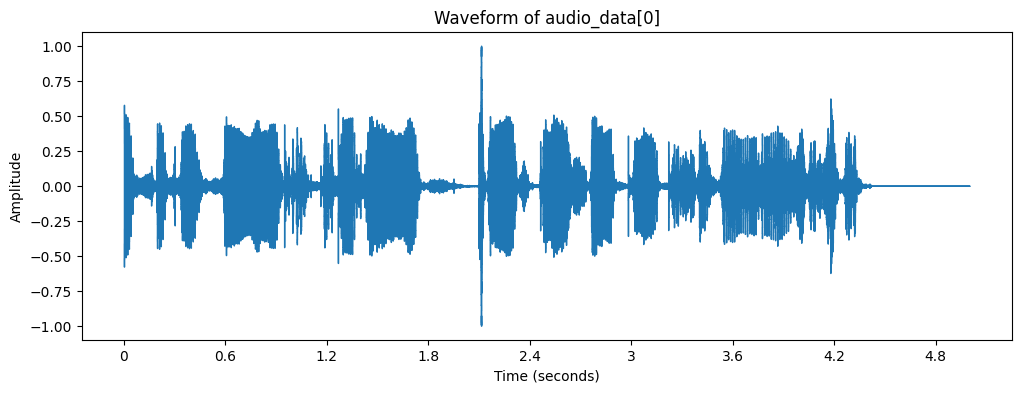

In [ ]:
plt.figure(figsize=(12, 4))
librosa.display.waveshow(audio_data[0], sr=16000)  # use waveshow (librosa>=0.8) or waveplot
plt.title("Waveform of audio_data[0]")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.show()

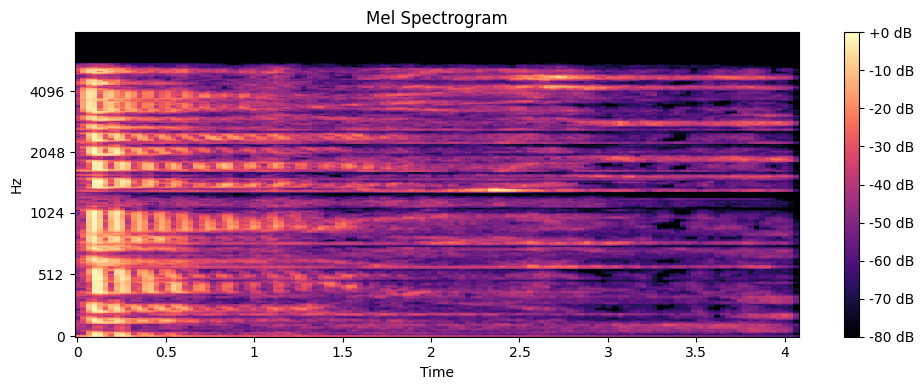

In [ ]:
# 3️⃣ Optional: visualize
plt.figure(figsize=(10, 4))
librosa.display.specshow(log_mel_sp[0], sr=16000, hop_length=512, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')
plt.tight_layout()
plt.show()

In [ ]:
def gmml_mask_spectrogram(feature):
    patch_size=16
    mask_ratio=0.7
    for spec in feature:
      time_dim, freq_dim = spec.shape
      nt, nf = time_dim // patch_size, freq_dim // patch_size
      patch_indices = [(i, j) for i in range(nt) for j in range(nf)]
      np.random.shuffle(patch_indices)
      num_masked = int(len(patch_indices) * mask_ratio)
      masked_spec = np.copy(spec)
      for (i, j) in patch_indices[:num_masked]:
          masked_spec[i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size] = 0
      gmml.append(masked_spec)

In [ ]:
gmml=[]
gmml_mask_spectrogram(log_mel_sp)

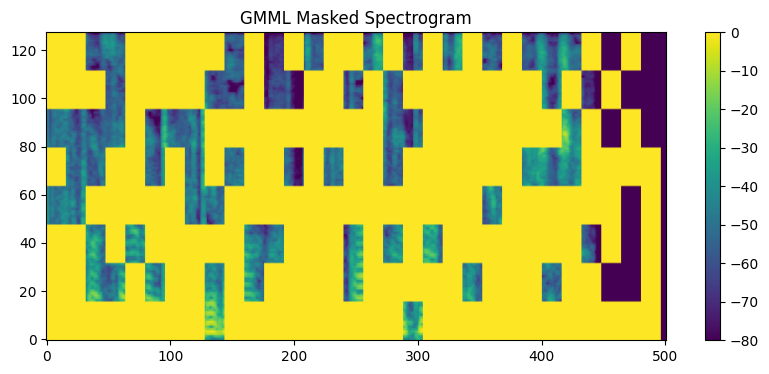

In [ ]:
plt.figure(figsize=(10, 4))
plt.imshow(gmml[0].T, aspect='auto', origin='lower')
plt.title('GMML Masked Spectrogram')
plt.colorbar()
plt.show()

# **Teacher-Student model**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
class AudioEncoder(nn.Module):
    def __init__(self):
        super(AudioEncoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        # Calculate the flattened size after convolutional layers
        # Assuming input size is (batch_size, 1, 128, 128)
        self._flattened_size = self._get_conv_output((1, 128, 128))

        self.fc = nn.Linear(self._flattened_size, 256)

    def _get_conv_output(self, shape):
        bs = 1
        input = torch.autograd.Variable(torch.rand(bs, *shape))
        output_feat = self.conv1(input)
        print(f"Shape after conv1: {output_feat.shape}")
        output_feat = self.conv2(output_feat)
        print(f"Shape after conv2: {output_feat.shape}")
        output_feat = self.conv3(output_feat)
        print(f"Shape after conv3: {output_feat.shape}")
        return int(np.prod(output_feat.size()))

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        local_feat = F.relu(self.bn3(self.conv3(x)))
        x = local_feat.view(x.size(0), -1)
        global_feat = self.fc(x)
        return local_feat, global_feat

In [ ]:
print("For Teacher: ")
teacher=AudioEncoder()
print("For Student: ")
student=AudioEncoder()

For Teacher: 
Shape after conv1: torch.Size([1, 32, 64, 64])
Shape after conv2: torch.Size([1, 64, 32, 32])
Shape after conv3: torch.Size([1, 128, 16, 16])
For Student: 
Shape after conv1: torch.Size([1, 32, 64, 64])
Shape after conv2: torch.Size([1, 64, 32, 32])
Shape after conv3: torch.Size([1, 128, 16, 16])


In [ ]:
for pra in teacher.parameters():
  pra.requires_grad=False


In [ ]:
optimizer=torch.optim.Adam(student.parameters(),lr=1e-4)

In [ ]:
# masked_specs = torch.randn(8, 1, 128, 128)
# # unmasked spectrogram (input to teacher)
# original_specs = torch.randn(8, 1, 128, 128)

import torchvision.transforms as transforms

# Define a transform to resize the spectrograms
resize_transform = transforms.Resize((128, 128))

# -----------------------------
# 4. Forward Pass
# -----------------------------
# Teacher on unmasked data (no gradient)
teacher_global=[]
for d in log_mel_sp:
  with torch.no_grad():
    # Convert NumPy array to Tensor and add channel dimension
    d_tensor = torch.from_numpy(d).unsqueeze(0).unsqueeze(0).float()
    # Resize the tensor to 128x128
    d_tensor = resize_transform(d_tensor)
    _, t = teacher(d_tensor)
    teacher_global.append(t)

# Student on masked data
student_local=[]
student_global=[]
for g in gmml:
  # Convert NumPy array to Tensor and add channel dimension
  g_tensor = torch.from_numpy(g).unsqueeze(0).unsqueeze(0).float()
  # Resize the tensor to 128x128
  g_tensor = resize_transform(g_tensor)
  x,y= student(g_tensor)
  student_local.append(x)
  student_global.append(y)

In [ ]:
loss = F.mse_loss(student_global, teacher_global)

optimizer.zero_grad()
loss.backward()
optimizer.step()

print("Training loss:", loss.item())

Training loss: 0.32947173714637756
